In [1]:
import sys
import glob
import os
import ee
import math
import pandas as pd
import numpy as np
import geopandas as gp

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

# from keras.models import Sequential, load_model
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras import regularizers, optimizers

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [18,16]
ee.Initialize()

In [2]:
# Numeric NLCD vals to class labels
nlcd= {0: "Open water",
1 : "Perennial ice/snow",
2 : "Developed",
3 : "Developed, low intensity",
4 : "Developed, medium intensity",
5 : "Developed high intensity",
6 : "Barren land (rock/sand/clay)",
7 : "Deciduous forest", 
8 : "Evergreen forest",
9 : "Mixed forest",
10 : "Dwarf scrub",
11 : "Shrub/scrub",
12 : "Grassland/herbaceous",
13 : "Sedge/herbaceous",
14 : "Lichens",
15 : "Moss",
16 : "Pasture/hay",
17 : "Cultivated crops",
18 : "Woody wetlands",
19 : "Emergent herbaceous wetlands"}


In [3]:
# Read data

In [4]:
states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]

In [5]:
# Read and formate data 
df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)
# Remove outliers
# df = df[~(np.abs(df.psi_rz-df.psi_rz.mean()) > (df.psi_rz.std()))]

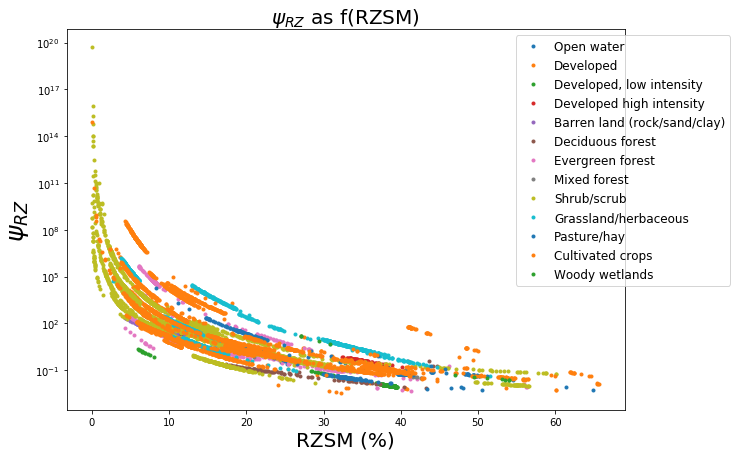

In [6]:
# Plot psi as f(SM) by lc type

groups = df.groupby('lc_type')

fig, ax = plt.subplots(figsize=(10,7))

for name, group in groups:
    ax.plot(group.rzsm, group.psi_rz, marker='o', linestyle='', ms=3, label=nlcd[name])
    
ax.legend(bbox_to_anchor=(1.2, 1),prop={'size': 12})
ax.set_title("$\psi_{RZ}$ as f(RZSM)", size = 20)
ax.set_ylabel("$\psi_{RZ}$", size = 25)
ax.set_yscale("log")
ax.set_xlabel("RZSM (%)", size = 20)

plt.show()

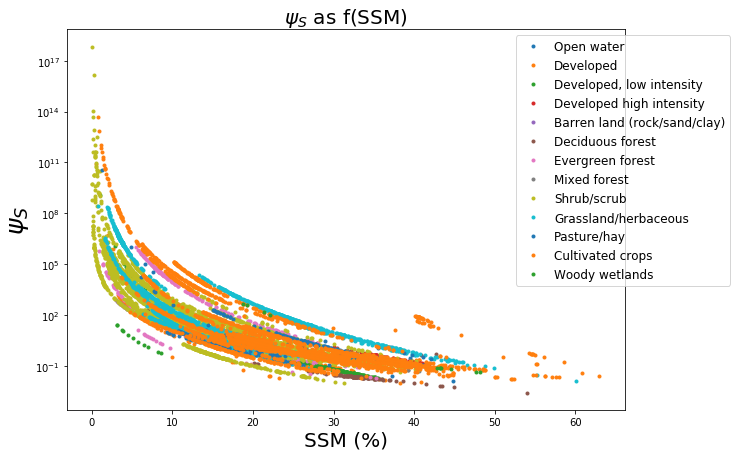

In [7]:
# Plot psi as f(SSM) by lc type

groups = df.groupby('lc_type')

fig, ax = plt.subplots(figsize=(10,7))

for name, group in groups:
    ax.plot(group.ssm, group.psi_s, marker='o', linestyle='', ms=3, label=nlcd[name])
    
ax.legend(bbox_to_anchor=(1.2, 1),prop={'size': 12})
ax.set_title("$\psi_{S}$ as f(SSM)", size = 20)
ax.set_ylabel("$\psi_{S}$", size = 25)
ax.set_yscale("log")
ax.set_xlabel("SSM (%)", size = 20)

plt.show()

In [8]:
# Filter the data. 

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

In [9]:
site_lens = {}
lc_col = {}
for i in df.site.unique():
    sdf = df[df.site==i]
    site_lens[i] = (len(sdf))
    try:
        lc_col[i]= nlcd[sdf.lc_type[0]]
    except:
        continue

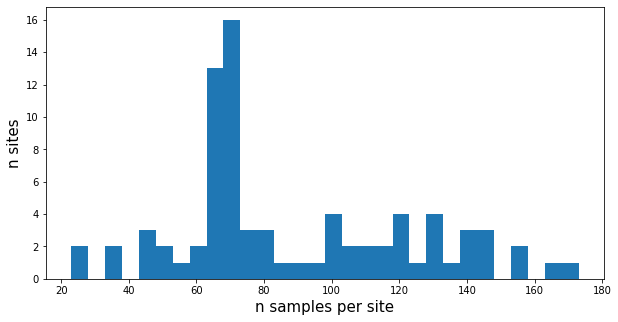

In [10]:
plt.figure(figsize = (10,5))
plt.hist(np.array(list(site_lens.values())), bins = 30)[-1]
plt.xlabel("n samples per site", size = 15)
plt.ylabel("n sites", size = 15)
plt.show()

In [11]:
t = pd.DataFrame.from_dict(list(site_lens.items()))
t.columns = ['site_id', 'len']

t2 = pd.DataFrame.from_dict(list(lc_col.items()))
t2.columns = ['site_id', 'type']

t = pd.merge(t,t2, on = "site_id")
# t.set_index('site_id', inplace = True);

In [12]:
gdf = pd.merge(sites,t,how = "inner", left_index = True, right_index = True)

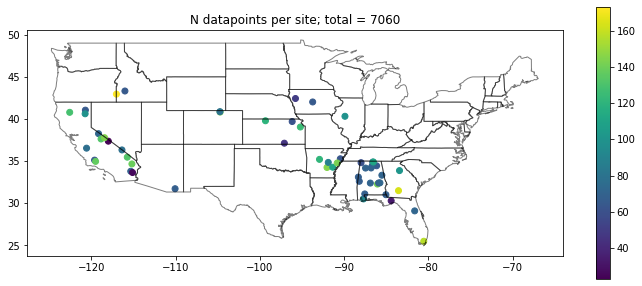

In [13]:
fig, ax = plt.subplots(figsize = (12,5))

ax.set_title("N datapoints per site; total = {}".format(sum(site_lens.values())))
gdf.plot(ax = ax, column = "len", legend = True)
states.plot(ax = ax, color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)
plt.show()

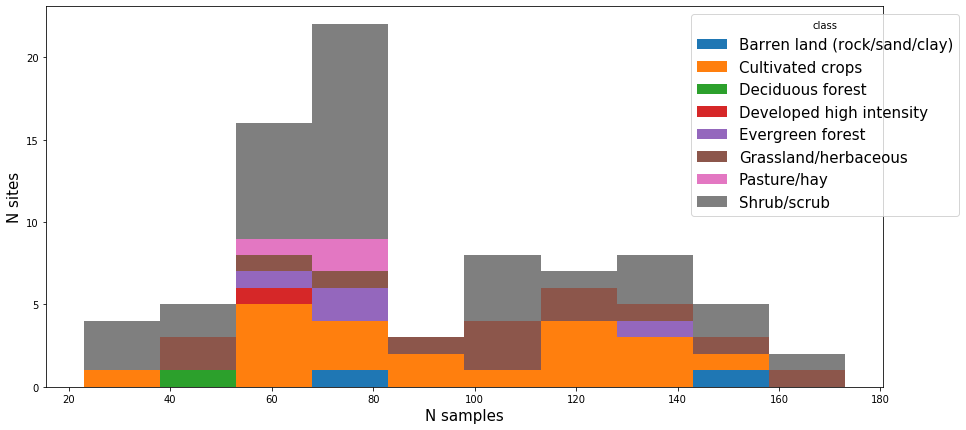

In [14]:
# Stacked histogram colored by landcover type
plt.figure(figsize=(15,7))

_, edges = np.histogram(t["len"], bins=10)
histdata = []; labels=[]
for n, group in t.groupby("type"):
    histdata.append(np.histogram(group["len"], bins=edges)[0])
    labels.append(n)

hist = np.array(histdata) 
histcum = np.cumsum(hist,axis=0)

plt.bar(edges[:-1],hist[0,:], width=np.diff(edges)[0],
            label=labels[0], align="edge")

for i in range(1,len(hist)):
    plt.bar(edges[:-1],hist[i,:], width=np.diff(edges)[0],
            bottom=histcum[i-1,:],label=labels[i], align="edge")

plt.legend(title="class", bbox_to_anchor=(1.1, 1), prop={'size': 15})
plt.ylabel("N sites", size = 15)
plt.xlabel("N samples", size = 15)
plt.show()

In [15]:
D = {}
for k,v in nlcd.items():
    t = df[df.lc_type == k]
    if len(t) == 0:
        continue
    else:
        D[v] = len(t)

Text(85.875, 0.5, 'n samples')

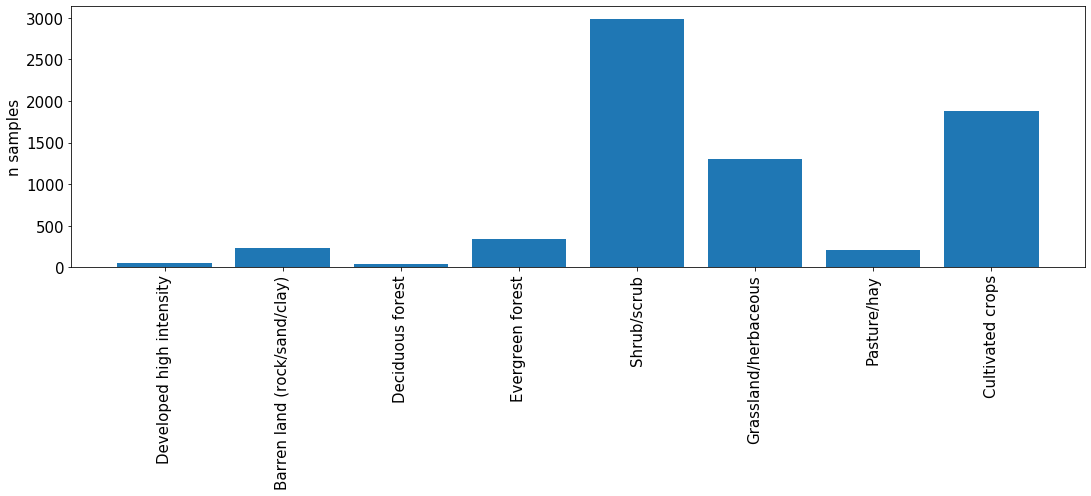

In [16]:
plt.figure(figsize = (15,7))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()), rotation='vertical', size = 15)
plt.yticks(size = 15)
plt.tight_layout()
plt.ylabel("n samples", size = 15)

In [17]:
# Calculate spectral indices

df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)


In [18]:
# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean 

vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))

/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


In [19]:
df['vv'] = vv_eff
df['hv'] = hv_eff

In [20]:
for i in df.site.unique():
    sdf = df[df.site==i]
    dr = pd.date_range(start = sdf.index[0], end = sdf.index[-1], freq = "12D")
    dt_idx = pd.DataFrame(dr)
    dt_df = rs.col_to_dt(dt_idx)
    fdf = pd.merge(dt_df, sdf, how = "inner", left_index = True, right_index = True)

In [21]:
def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 

site_lags = {}
for j in df.site.unique():
    sdf = df[df.site==j]
    lags = []
    for i,x in enumerate(sdf.index[:-1]):
        lags.append((sdf.index[i+1] - sdf.index[i]).days)
    site_lags[j] = most_frequent(lags)
    
l = pd.DataFrame.from_dict(list(site_lags.items()))
l.columns = ['site_id', 'lags']


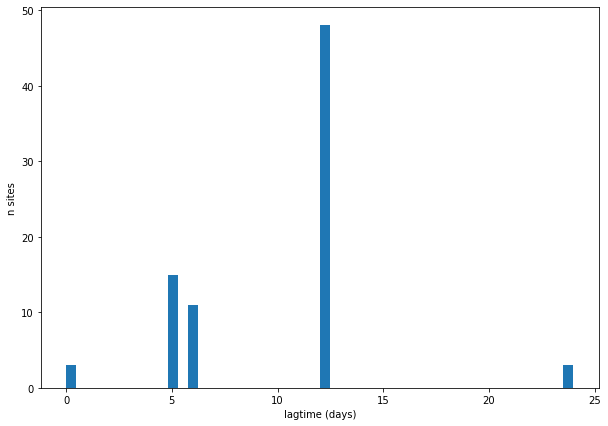

In [22]:
plt.figure(figsize = (10,7))
plt.hist(site_lags.values(), bins = 50)
plt.xlabel("lagtime (days)")
plt.ylabel("n sites")
plt.show()

In [23]:
gdf2 = pd.merge(sites,l,how = "inner", left_index = True, right_index = True)

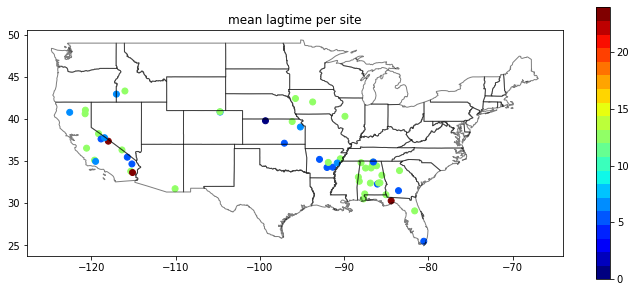

In [24]:
fig, ax = plt.subplots(figsize = (12,5))

cmap = plt.get_cmap('jet', 20)

ax.set_title("mean lagtime per site")
gdf2.plot(ax = ax, column = "lags", cmap = cmap, legend = True)
states.plot(ax = ax, color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)
plt.show()

In [25]:
lag_lens = []
for i in df.site.unique():
    sdf = df[df.site==i]
    for i in sdf.index[2:-1]:
        end = i
        begin = end - pd.Timedelta(weeks=5)
        lag_lens.append(len(sdf.loc[begin:end]))

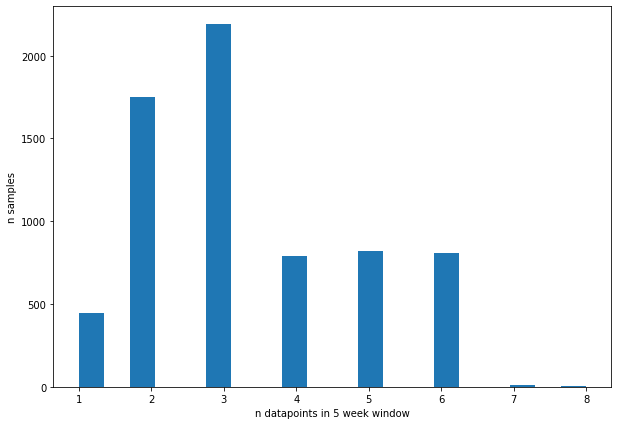

In [26]:
plt.figure(figsize = (10,7))
plt.hist(lag_lens, bins = 20)
plt.xlabel("n datapoints in 5 week window")
plt.ylabel("n samples")
plt.show()


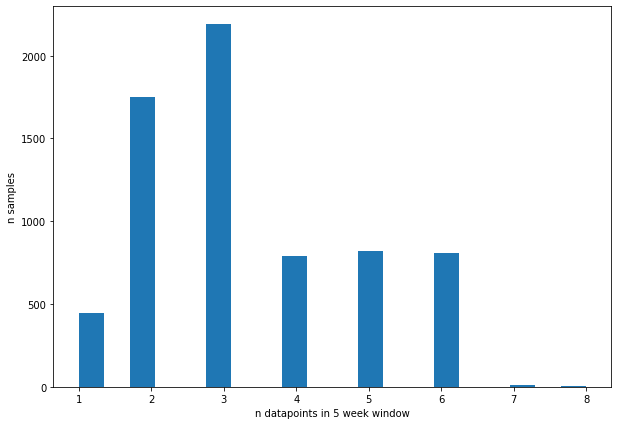

In [27]:
plt.figure(figsize = (10,7))
plt.hist(lag_lens, bins = 20)
plt.xlabel("n datapoints in 5 week window")
plt.ylabel("n samples")
plt.show()


In [229]:
def calc_n_rows(window_size):
    filtered = []

    for i in df.site.unique():
        sdf = df[df.site==i]

        for i in sdf.index:                
            end = i
            begin = end - pd.Timedelta(days=window_size)
            t = sdf[sdf.date.between(begin, end)]
            num_points = len(t)
            if num_points>6:
                filtered.append(t)

    f = pd.concat(filtered).drop_duplicates(subset=['date', 'site'])
    
    return len(f)/2

In [234]:
nrows = []
windows = np.linspace(30,60,31)

In [235]:
for i in windows:
    nrows.append(calc_n_rows(i))

Text(0.5, 0, 'timelag(days)')

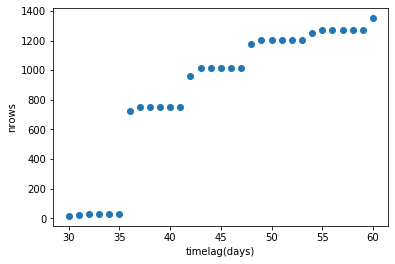

In [237]:
plt.scatter(windows, nrows)
plt.ylabel("nrows")
plt.xlabel("timelag(days)")

In [238]:
len(nrows[-1].dropna())

AttributeError: 'float' object has no attribute 'dropna'

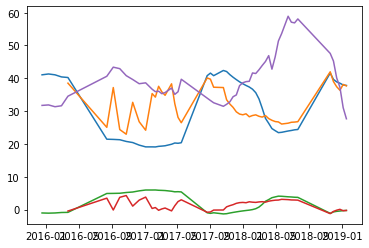

In [127]:
plt.plot(d[d['site'] == 2006].rzsm)
plt.plot(d[d['site'] == 2006].ssm)
plt.plot(np.log(d[d['site'] == 2006].psi_rz))
plt.plot(np.log(d[d['site'] == 2006].psi_s))
# plt.plot((d[d['site'] == 2006].vv))
# plt.plot((d[d['site'] == 2006].hv))
plt.plot((d[d['site'] == 2006].B1_filt)*1000)

In [ ]:
asdf = pd.concat(fin_sites)
len(asdf.drop_duplicates(subset=['date'], keep=False))

In [ ]:
t=asdf.drop_duplicates(subset=['date'], keep=False)

In [ ]:
plt.scatter(t.hv,t.ssm)
plt.scatter(t.vv,t.ssm)
plt.scatter(t.vv,t.rzsm)
plt.scatter(t.hv,t.rzsm)

In [ ]:
df['vv_t1'] = df.groupby('site')['vv'].shift(1)
df['hv_t1'] = df.groupby('site')['hv'].shift(1)
df['vv_t2'] = df.groupby('site')['vv'].shift(2)
df['hv_t2'] = df.groupby('site')['hv'].shift(2)

In [ ]:
# df["vv_t3"] = df.groupby('site')['vv'].shift(3)
# df["hv_t3"] = df.groupby('site')['hv'].shift(3)
# df["vv_t4"] = df.groupby('site')['vv'].shift(4)
# df["hv_t4"] = df.groupby('site')['hv'].shift(4)

In [ ]:
testsite = df[df.site == 2019]

In [ ]:
plt.figure(figsize = (12,5))
plt.scatter(testsite.index,testsite.vv_t1)
plt.scatter(testsite.index,testsite.rzsm)

In [ ]:
# RF / RNN

In [ ]:
df = df.dropna()

In [ ]:
# One hot encode the landcover types 
one_hot = pd.get_dummies(df.lc_type, drop_first=True )

In [ ]:
# Select dependent variable, drop fluff from input (independent) feats
y = df.psi_rz # Psi_RZ? 
X = df.drop(["site","date","rzsm", "ssm", "psi_rz", "psi_s", "lc_type"], axis=1)

In [ ]:
# Train test split for validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale inputs
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Concat the one hot df to the scaled df
X = pd.concat([X, one_hot], axis = 1)

In [ ]:
# Run the actual RF 

regressor = RandomForestRegressor(n_estimators=5000, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
# Make predictions on test data using the model trained on original data
predictions = regressor.predict(X_test)
# Performance metrics
errors = abs(predictions - y_test)
print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')